<a href="https://colab.research.google.com/github/Meidyt/Hatespeech/blob/main/Tugashatesp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate speech in Bahasa**
Pada tugas kali ini adalah mengklasifikasikan suatu tulisan apakah termasuk kelompok "hate speech" atau tidak.

### Import library dan data set
Pertama-tama seperti biasa, kita melakukan semua import library yang sekiranya akan digunakan. 

In [72]:
! pip3 install nltk
! pip3 install Sastrawi
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('https://raw.githubusercontent.com/Meidyt/Hatespeech/main/Dataset_hatespeech.csv' , sep=",", dtype=str)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


### Data Prepocessing
Selanjutnya masuk ke preprocessing dari suatu data. Pertama-tama kita cek apakah data ini ada kolom kosong atau tidak. 

In [73]:
print(df.isnull().values.any())

False


Jika tidak ada, maka kita akan sajikan data set ke 2 kelompok yaitu hate speech dan non hate speech.

In [74]:
count_label =df.Label.value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='Label')


Lalu, setelah itu kita melakukan perubahan-perubahan pada data set dengan mengubah dan menghapus beberapa tanda baca. 

In [75]:
# Convert text to lowercase
df['Tweet'] = df['Tweet'].str.lower()

# Remove Twitter Post Link and RT word
df['Tweet'] = df['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'rt', '', regex=True)

# Remove number
df['Tweet'] = df['Tweet'].str.replace('\d+', '')

# Remove Punctuation
df['Tweet'] = df['Tweet'].str.replace('[^\w\s]','')

# Remove Whitespaces
df["Tweet"] = df['Tweet'].str.strip()

# Tokenization
df["Tweet"] = df["Tweet"].apply(nltk.word_tokenize)

# StopWords Removal
stop_words = set(stopwords.words('indonesian'))
df["Tweet"] = df["Tweet"].apply(lambda x: [item for item in x if item not in stop_words])

# Stemming Indonesian
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df["Tweet"] = df["Tweet"].apply(lambda x: [ stemmer.stem(item) for item in x])

df.head()

,Label,Tweet
0,Non_HS,"[spardaxyz, fadli, zon, mendagri, nonaktif, ah..."
1,Non_HS,"[baguscondromowo, luka, aksi, rangka, penjara,..."
2,Non_HS,"[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,Non_HS,"[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,"[lisdaulay, waspada, ktp, palsukawal, pilkada]"


Selanjutnya kita melihat plot data dengan gambar, sehingga dapat diketahui kata-kata yang dominan digunakan pada data set. 

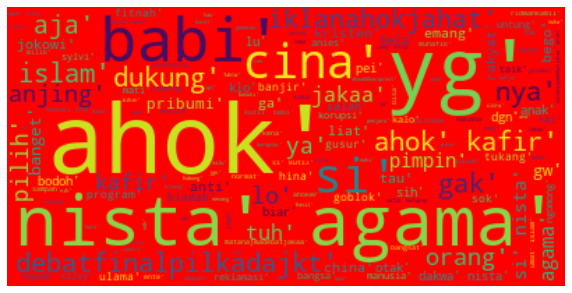

In [85]:
word = df.Tweet[df['Label']=='HS'].astype('string')
word.head()
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="red").generate_from_text(' '.join(word))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Data Training & Testing
Untuk selanjutnya masuk ke pembagian jumlah data yang akan dilatih dan dites. Untuk kali ini saya menggunakan 30% untuk data latih dan 70% untuk data tes. 

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test  = train_test_split(df['Tweet'] , df['Label'], shuffle = True, test_size=0.3, random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(499,)
(214,)
(499,)
(214,)


### Support Vector Machine 
Selanjutnya masuk ke metode SVM untuk melatih data. 

In [78]:
svm = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), SVC(random_state=1, probability=True))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1]
pg_svm = [{'svc__C':r, 'svc__kernel':['linear']}]

gs_svm = GridSearchCV(estimator= svm,                    
                    param_grid= pg_svm,
                    scoring='accuracy',
                    cv=2)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

y_pred_svm = gs_svm_best.predict(X_test)

acc_svm = metrics.accuracy_score(y_test, y_pred_svm)
prec_svm = metrics.precision_score(y_test, y_pred_svm, pos_label='Non_HS')
rec_svm = metrics.recall_score(y_test, y_pred_svm, pos_label='Non_HS')
f1_svm = metrics.f1_score(y_test, y_pred_svm, pos_label='Non_HS')
kappa_svm = metrics.cohen_kappa_score(y_test, y_pred_svm)

print("Accuracy:", acc_svm)
print("Precision:", prec_svm)
print("Recall:", rec_svm)
print("F1 Score:", f1_svm)
print("Cohens Kappa Score:", kappa_svm)

# Visualize ROC Curve
y_pred_svm_proba = gs_svm_best.predict_proba(X_test)[::,1]
fprsvm, tprsvm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba, pos_label="Non_HS")
aucsvm = metrics.roc_auc_score(y_test, y_pred_svm_proba)

Accuracy: 0.8785046728971962
Precision: 0.8768115942028986
Recall: 0.9307692307692308
F1 Score: 0.9029850746268656
Cohens Kappa Score: 0.7408718330849479


### Artificial Neural Networks
Selanjutnya mencoba dengan metode lain yaitu ANN

In [79]:
ann = make_pipeline(TfidfVectorizer(lowercase=False, preprocessor=' '.join), MLPClassifier())

# grid searh to choose the best (combination of) hyperparameters
parameter_space = {
    'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

gs_ann = GridSearchCV(estimator=ann, 
                      param_grid=parameter_space,
                      scoring='accuracy',
                      cv=2,
                    )

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_ann_scores = cross_val_score(gs_ann, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_ann.fit(X_train, y_train)
gs_ann_best=gs_ann.best_estimator_
gs_ann_best.fit(X_train, y_train)

y_pred_ann = gs_ann_best.predict(X_test)

acc_ann = metrics.accuracy_score(y_test, y_pred_ann)
prec_ann = metrics.precision_score(y_test, y_pred_ann, pos_label='Non_HS')
rec_ann = metrics.recall_score(y_test, y_pred_ann, pos_label='Non_HS')
f1_ann = metrics.f1_score(y_test, y_pred_ann, pos_label='Non_HS')
kappa_ann = metrics.cohen_kappa_score(y_test, y_pred_ann)

print("Accuracy:", acc_ann)
print("Precision:", prec_ann)
print("Recall:", rec_ann)
print("F1 Score:", f1_ann)
print("Cohens Kappa Score:", kappa_ann)

# Visualize ROC Curve
y_pred_ann_proba = gs_ann_best.predict_proba(X_test)[::,1]
fprann, tprann, _ = metrics.roc_curve(y_test,  y_pred_ann_proba, pos_label="Non_HS")
aucann = metrics.roc_auc_score(y_test, y_pred_ann_proba)

Accuracy: 0.8785046728971962
Precision: 0.8714285714285714
Recall: 0.9384615384615385
F1 Score: 0.9037037037037037
Cohens Kappa Score: 0.7397567820392891


### Output
Berdasarkan kedua metode yang telah digunakan, maka dapat didapatkan perbandingan akurasi seperti di grafik. 

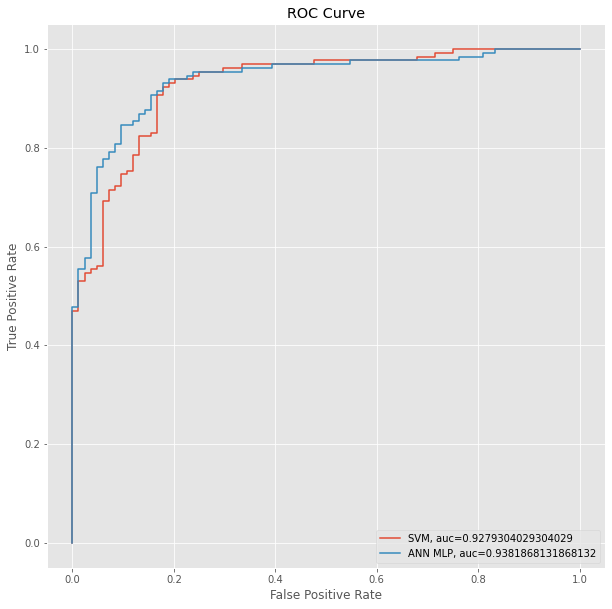

In [80]:
# Set Size and Style
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Comparing ROC Curve
plt.plot(fprsvm,tprsvm,label="SVM, auc="+str(aucsvm))
plt.plot(fprann,tprann,label="ANN MLP, auc="+str(aucann))

# plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()